# **Primera iteración**

### Entendimiento y preparación de los datos

In [ ]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from seaborn import heatmap
from sklearn.preprocessing import scale, LabelEncoder, quantile_transform
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

# Nombres de los atributos numéricos y categóricos
numeric_att = ['age', 'bp', 'sg', 'al', 'su','bgr', 'bu', 'sc', 'sod', 'pot', 
               'hemo', 'pcv', 'wbcc', 'rbcc']

categorical_att = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 
                   'ane', 'class']

# Carga los datos (desde un repositorio en GitHub)
url="https://raw.githubusercontent.com/paladinescamila/Parcial-2-AA/main/data.csv"
data = pd.read_csv(url, header=None)

data.columns = ["age", "bp", "sg", "al", "su", "rbc", "pc", "pcc", "ba", "bgr", 
                "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc", "htn", 
                "dm", "cad", "appet", "pe", "ane", "class"]

data.replace('?', np.nan, inplace=True)

# Eliminar los registros con más de 5 datos faltantes (Paso 1 del Plan de Ajuste)
data.dropna(thresh=20, inplace=True)

# Reemplazar los datos faltantes por la media o la moda (Paso 2 del Plan de Ajuste)
for i in numeric_att:
    data[i] = pd.to_numeric(data[i], errors='coerce')
    data[i].fillna(data[i].mean(), inplace=True)

for i in categorical_att:
    data[i].fillna(data[i].mode()[0], inplace=True)

# Resuelve algunos problemas de escritura de los datos
mapping = {"\tyes": "yes", "\tno": "no", " yes": "yes", " no": "no"}
boolean = ['htn', 'dm', 'cad', 'pe', 'ane']

for i in boolean: data[i] = data[i].replace(mapping)

data['class'] = data['class'].replace({"ckd\t": "ckd"})

data

In [ ]:
# Cantidad de registros y atributos
data.shape

In [ ]:
# Tipo de los atributos
data.dtypes

In [ ]:
# Medidas de centralidad y dispersión (atributos numéricos)
data.describe()

In [ ]:
# Diagrama de cajas y bigotes (atributos númericos)
plt.boxplot((data['age'], data['bp'], data['sg'], data['al'],data['su'], 
             data['bgr'], data['bu'], data['sc'], data['sod'], data['pot'], 
             data['hemo'], data['pcv'], data['wbcc'], data['rbcc']))
plt.show()

In [ ]:
# Medidas de centralidad (atributos categóricos)
data.mode()

In [ ]:
# Distribución de los datos (atributos categóricos)
for i in categorical_att:
    plt.title(i)
    plt.hist(data[i])
    plt.show()

In [ ]:
# Cantidad de duplicados por clase
levels = data.groupby(['class'])
for name, group in levels:
    print(name, group[group.duplicated()].count()[0])

In [ ]:
# Correlación (tabla)
data.corr()

In [ ]:
# Correlación (gráfica)
plt.subplots(figsize=(20,15))
heatmap(data.corr(), square=True, annot=True)

In [ ]:
# Datos atípicos de cada atributo
for i in numeric_att:
    plt.title(i)
    plt.boxplot(data[i])
    plt.show()

In [ ]:
# Cantidad de registros sin valores atípicos
temp = data[numeric_att]
temp[(np.abs(stats.zscore(temp)) < 3).all(axis=1)].count()[0]

In [ ]:
# Cantidad de registros con valores atípicos por clase
levels = data.groupby(['class'])
names, outliers, total = [], [], []
for name, group in levels:
    numeric = group[numeric_att]
    names += [name]
    outliers += [numeric[(np.abs(stats.zscore(numeric)) > 3).any(axis=1)].count()[0]]
    total += [group.count()[0]]

pd.DataFrame({'Outliers': outliers, 'Total':total}, index=names).plot(kind='bar')

In [ ]:
# Datos faltantes por cada atributo
# for i in categorical_att: print("{}\t{}".format(i, data[data[i] == "?"][i].count()))
# for i in numeric_att: print("{}\t{}".format(i, data[data[i] == -1][i].count()))

In [ ]:
# Datos faltantes por clase
# clase_1, clase_2 = 0, 0
# data_1 = data[data['class'] == "ckd"]
# data_2 = data[data['class'] == "notckd"]

# for i in categorical_att: 
#     clase_1 += data_1[data_1[i] == "?"][i].count()
#     clase_2 += data_2[data_2[i] == "?"][i].count()

# for i in numeric_att: 
#     clase_1 += data_1[data_1[i] == -1][i].count()
#     clase_2 += data_2[data_2[i] == -1][i].count()

# print("ckd", clase_1)
# print("notckd", clase_2)

In [ ]:
# Cantidad de registros por clase
data['class'].value_counts()

In [ ]:
# Gráfica de la cantidad de registros por clase
data['class'].value_counts().plot(kind='bar')

#### Conclusiones sobre el entendimiento de los datos

- No hay registros duplicados.
- Los atributos "pcv" y "hemo" son altamente correlacionados (0.85), por lo que se eliminará uno de ellos, así como "rbcc" y "hemo".
- Hay bastantes atributos con valores atípicos en ambas clases, pero consideramos que son importantes para la construcción del modelo, por lo que no se van a eliminar.
- Hay 242 registros con al menos un dato faltante.
- Un 62.5% de los registros hacen parte de la clase mayoritaria, por lo que no está completamente balanceado.
- La principal dificultad con el dataset es que hay bastantes datos faltantes.
- No es necesario discretizar algún atributo.
- Es necesario normalizar la mayoría de los atributos.
- Es necesario pasar los atributos categóricos a numéricos.

#### Plan de ajuste de datos

1. Eliminar los registros con más de 5 datos faltantes (realizado anteriormente).
2. Reemplazar los datos faltantes por la media o la moda según el tipo del atributo (realizado anteriormente).
3. Eliminar los atributos "pcv" y "rbcc" para eliminar la correlación con "hemo".
4. Normalizar el atributo "wbcc".
5. Pasar los atributos categóricos a numéricos.

> Los pasos 1 y 2 se realizaron necesariamente al principio para poder analizar las estadísticas.

In [ ]:
# Paso 3: Eliminar los atributos "pcv" y "rbcc"
data = data.drop('pcv', axis=1)
data = data.drop('rbcc', axis=1)
data

In [ ]:
# Paso 4: Normalizar los atributos numéricos
data['wbcc'] = scale(data['wbcc'])
data

In [ ]:
# Paso 5: Pasar los atributos categóricos a numéricos
categorize = data.apply(LabelEncoder().fit_transform)
for i in categorical_att:
    data[i] = categorize[i]
data

### Entrenamiento de los modelos

In [13]:
# Separación de los datos
X, y = data.drop('class', axis=1), data['class']
f1s = [0 for _ in range(5)]

def print_metrics(metrics):

    print("Métrica\tPromedio\tDesviación\tMínimo\tMáximo")
    nombres = ["Precision", "Recall", "F1-score", "Accuracy"]

    for i in range(4):
        mean = np.mean(metrics[i])
        std = np.std(metrics[i])
        min_ = np.min(metrics[i])
        max_ = np.max(metrics[i])
        print("{}\t{:.5f}\t{:.5f}\t{:.5f}\t{:.5f}".format(nombres[i], mean, std, min_, max_))


In [ ]:
# Perceptrón

parameter_space = [{'hidden_layer_sizes': [(10,10,10,10), (50,50,50,50), (100,100,100)], 
                        'activation': ['logistic', 'tanh', 'relu'], 'max_iter': [700, 1000],
                        }]

metrics = [[] for i in range(4)]

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    MLP = MLPClassifier()

    MLP = GridSearchCV(MLP, parameter_space, n_jobs=-1, cv=7, refit=True)
    MLP.fit(X_train, y_train)

    # print("Mejores parametros:")
    # print(MLP.best_params_)
        
    prediction = MLP.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[0] = np.mean(metrics[2])
print_metrics(metrics)

In [ ]:
# Máquinas de vectores de soporte

parameter_space = [{'C': [1.5, 2, 2.5, 3], 'kernel': ['linear','rbf'], 
                    'gamma': ['scale', 'auto']}]

metrics = [[] for i in range(4)]

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    SVM = SVC()

    SVM = GridSearchCV(SVM, parameter_space, n_jobs=-1, cv=5, refit=True)
    SVM.fit(X_train, y_train)

    # print("Mejores parametros:")
    # print(SVM.best_params_)
        
    prediction = SVM.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[1] = np.mean(metrics[2])
print_metrics(metrics)

In [ ]:
# Regresión Logística

parameter_space = [{'solver': ['newton-cg', 'lbfgs','liblinear','sag','saga'], 
                    'max_iter': [2000,3000,4000,5000],
                    }]

metrics = [[] for i in range(4)]

for i in range(10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = LogisticRegression()

    clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=3, refit=True)
    clf.fit(X_train,y_train)

    # print("Mejores parametros:")
    # print(clf.best_params_)
    
    prediction = clf.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[2] = np.mean(metrics[2])
print_metrics(metrics)

In [ ]:
# K-vecinos

parameter_space = [{'n_neighbors': [i for i in range(3, 20)], 
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    }]

metrics = [[] for i in range(4)]

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    neigh = KNeighborsClassifier()

    neigh = GridSearchCV(neigh, parameter_space, n_jobs=-1, cv=10, refit=True)
    neigh.fit(X_train, y_train)

    # print("Mejores parametros:")
    # print(neigh.best_params_)

    prediction = neigh.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[3] = np.mean(metrics[2])
print_metrics(metrics)

In [ ]:
# Análisis Discriminante Lineal

parameter_space = [{'solver': ['svd', 'lsqr', 'eigen']}]

metrics = [[] for i in range(4)]

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    LDA = LinearDiscriminantAnalysis()

    LDA = GridSearchCV(LDA, parameter_space, n_jobs=-1, cv=3, refit=True)
    LDA.fit(X_train,y_train)

    # print("Mejores parametros:")
    # print(LDA.best_params_)
        
    prediction = LDA.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[4] = np.mean(metrics[2])
print_metrics(metrics)

### Análisis de los resultados

Como se puede observar en la siguiente gráfica, los métodos que tuvieron el mejor desempeño fueron SVM y Regresión Logística, teniendo en cuenta la estimación de parámetros que se hizo.



Perceptrón: 0.91714
SVM: 0.96751
Regresión Logística: 0.96637
K-vecinos: 0.83067
Análisis Discriminante Lineal: 0.93929


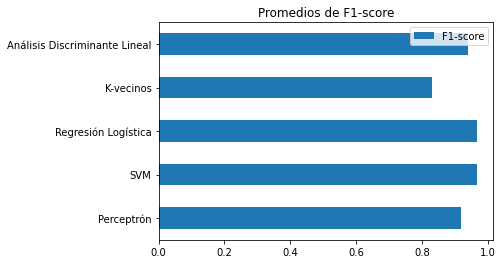

In [ ]:
techniques = ['Perceptrón', 'SVM', 'Regresión Logística', 'K-vecinos', 'Análisis Discriminante Lineal']
pd.DataFrame({'F1-score': f1s}, index=techniques).plot(kind='barh', title="Promedios de F1-score")
for i in range(5): print("{}: {:.5f}".format(techniques[i], f1s[i]))

# **Segunda iteración**

# **Tercera iteración**